## <font color = "Navy"> This notebook is a comprehensive program used to train different models for Facial Emotion Recognition 

### <font color= "Indigo">Project Team:
<ol>
  <font color= "Indigo"><li>Kavya Pothula</li>
  <li>Anjul Jain</li>
  <li>Uttara Dabbiru</li>
    <li>Manushree Sannathimmappa</li>
</ol>

### Import libraries

In [1]:
import numpy as np
import cv2
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

### Load dataset

In [2]:
train_dir = 'data/train'
val_dir = 'data/test'
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        class_mode='categorical')
validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Found 7858 files belonging to 1 classes.


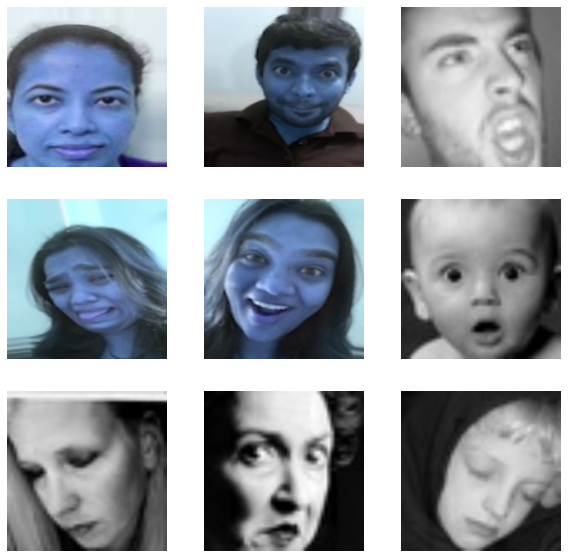

In [71]:
import matplotlib.pyplot as plt
import tensorflow as tf
img_height, img_width = 256, 256
batch_size = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/train',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=None)

plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

### Build a model : CNN

In [72]:
emotion_model_1 = Sequential()
emotion_model_1.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(48,48,3)))
emotion_model_1.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
emotion_model_1.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model_1.add(Dropout(0.25))
emotion_model_1.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
emotion_model_1.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model_1.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
emotion_model_1.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model_1.add(Dropout(0.25))
emotion_model_1.add(Flatten())
emotion_model_1.add(Dense(16, activation='relu'))
emotion_model_1.add(Dropout(0.5))
emotion_model_1.add(Dense(7, activation='softmax'))

In [73]:
emotion_model_1.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001, decay=1e-6),metrics=['accuracy'])
emotion_model_1_history = emotion_model_1.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=7179 // 64)

Epoch 1/10
448/448 [==============================] - 200s 445ms/step - loss: 1.9219 - accuracy: 0.2334 - val_loss: 1.9016 - val_accuracy: 0.2467
Epoch 2/10
448/448 [==============================] - 219s 489ms/step - loss: 1.9015 - accuracy: 0.2375 - val_loss: 1.8907 - val_accuracy: 0.2471
Epoch 3/10
448/448 [==============================] - 226s 504ms/step - loss: 1.8840 - accuracy: 0.2406 - val_loss: 1.8586 - val_accuracy: 0.2471
Epoch 4/10
448/448 [==============================] - 230s 513ms/step - loss: 1.8555 - accuracy: 0.2441 - val_loss: 1.8252 - val_accuracy: 0.2475
Epoch 5/10
448/448 [==============================] - 232s 519ms/step - loss: 1.8304 - accuracy: 0.2470 - val_loss: 1.7899 - val_accuracy: 0.2531
Epoch 6/10
448/448 [==============================] - 224s 500ms/step - loss: 1.8060 - accuracy: 0.2531 - val_loss: 1.7678 - val_accuracy: 0.2853
Epoch 7/10
448/448 [==============================] - 225s 503ms/step - loss: 1.7805 - accuracy: 0.2666 - val_loss: 1.7276 -

In [74]:
print('Maximum training accuracy:', round(max(emotion_model_1_history.history['accuracy'])*100,2))
print('Maximum validation accuracy:', round(max(emotion_model_1_history.history['val_accuracy'])*100,2))

Maximum training accuracy: 29.17
Maximum validation accuracy: 38.34


In [75]:
emotion_model_1.save('saved_model_CNN.h5')

In [76]:
model_cnn = keras.models.load_model('saved_model_CNN.h5')

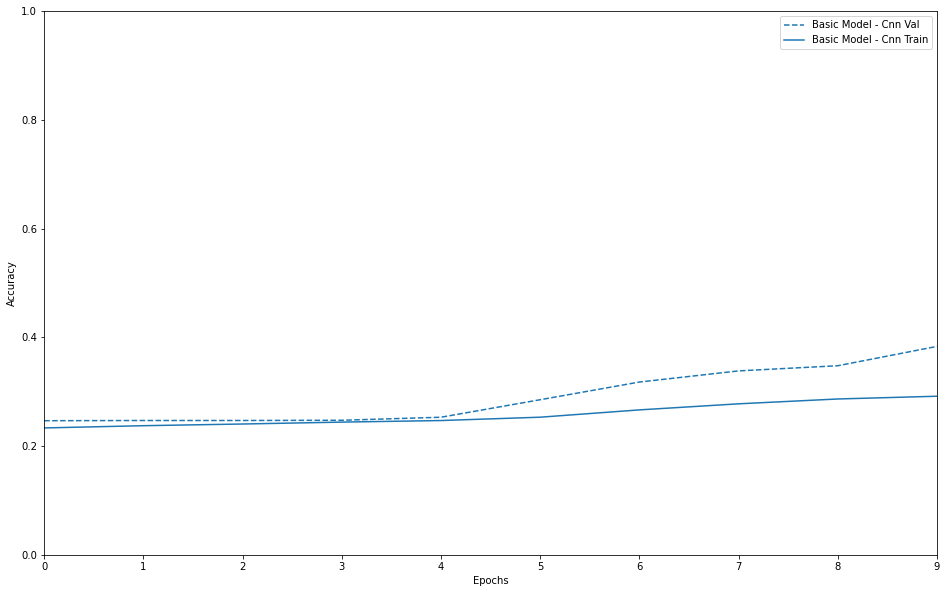

In [77]:
import matplotlib.pyplot as plt

def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  plt.ylim([0,1])

plot_history([('Basic Model - CNN', emotion_model_1_history)])

### VGG16 - Building a Basic Model

In [78]:
# Not including the top layer
vgg = VGG16(weights='imagenet', include_top=False,input_shape=(48, 48, 3 ))

# Freezing all the layers except last 4
for layer in vgg.layers[:-4]:
    layer.trainable = False
# Checking the trainable status of each layer
for layer in vgg.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ff81b90d820> False
<keras.layers.convolutional.Conv2D object at 0x7ff81b90dcd0> False
<keras.layers.convolutional.Conv2D object at 0x7ff820abc6d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff81b90dbe0> False
<keras.layers.convolutional.Conv2D object at 0x7ff81b91d550> False
<keras.layers.convolutional.Conv2D object at 0x7ff81b9195b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff820abc880> False
<keras.layers.convolutional.Conv2D object at 0x7ff81b92d580> False
<keras.layers.convolutional.Conv2D object at 0x7ff81b92d8b0> False
<keras.layers.convolutional.Conv2D object at 0x7ff81b92d8e0> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff81b92d340> False
<keras.layers.convolutional.Conv2D object at 0x7ff81b938e20> False
<keras.layers.convolutional.Conv2D object at 0x7ff81b938ee0> False
<keras.layers.convolutional.Conv2D object at 0x7ff81b9384c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7ff81b934370>

In [79]:
# Create the model
emotion_model_2 = Sequential()

# Add the vgg convolutional base model
emotion_model_2.add(vgg)
emotion_model_2.add(Flatten())
emotion_model_2.add(Dense(128, activation='relu'))
emotion_model_2.add(BatchNormalization())
emotion_model_2.add(Dropout(0.25))
emotion_model_2.add(Dense(64, activation='relu'))
emotion_model_2.add(BatchNormalization())
emotion_model_2.add(Dropout(0.25))
emotion_model_2.add(Dense(32, activation='relu'))
emotion_model_2.add(BatchNormalization())
emotion_model_2.add(Dropout(0.25))
emotion_model_2.add(Dense(16, activation='relu'))
emotion_model_2.add(BatchNormalization())
emotion_model_2.add(Dropout(0.25))
emotion_model_2.add(Dense(16, activation='relu'))
emotion_model_2.add(BatchNormalization())
emotion_model_2.add(Dropout(0.25))
emotion_model_2.add(Dense(7, activation= 'softmax'))

emotion_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)               

In [80]:
emotion_model_2.compile(optimizer="adam", 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [81]:
emotion_model_2_history = emotion_model_2.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=7179 // 64)

/Users/manushreets/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
448/448 [==============================] - 402s 894ms/step - loss: 2.0600 - accuracy: 0.1949 - val_loss: 1.9207 - val_accuracy: 0.1805
Epoch 2/10
448/448 [==============================] - 374s 834ms/step - loss: 1.7073 - accuracy: 0.3216 - val_loss: 1.6830 - val_accuracy: 0.3657
Epoch 3/10
448/448 [==============================] - 382s 853ms/step - loss: 1.5483 - accuracy: 0.3999 - val_loss: 1.5773 - val_accuracy: 0.3640
Epoch 4/10
448/448 [==============================] - 375s 837ms/step - loss: 1.4909 - accuracy: 0.4257 - val_loss: 1.8356 - val_accuracy: 0.2670
Epoch 5/10
448/448 [==============================] - 385s 859ms/step - loss: 1.4528 - accuracy: 0.4428 - val_loss: 1.7399 - val_accuracy: 0.2614
Epoch 6/10
448/448 [==============================] - 385s 859ms/step - loss: 1.4204 - accuracy: 0.4569 - val_loss: 1.3995 - val_accuracy: 0.4488
Epoch 7/10
448/448 [==============================] - 372s 830ms/step - loss: 1.3780 - accuracy: 0.4780 - val_loss: 1.4495 -

In [82]:
print('Maximum training accuracy:', round(max(emotion_model_2_history.history['accuracy'])*100,2))
print('Maximum validation accuracy:', round(max(emotion_model_2_history.history['val_accuracy'])*100,2))

Maximum training accuracy: 51.95
Maximum validation accuracy: 49.04


In [83]:
emotion_model_2.save('saved_model_VGG_1.h5')

In [84]:
model_vgg_1 = keras.models.load_model('saved_model_VGG_1.h5')

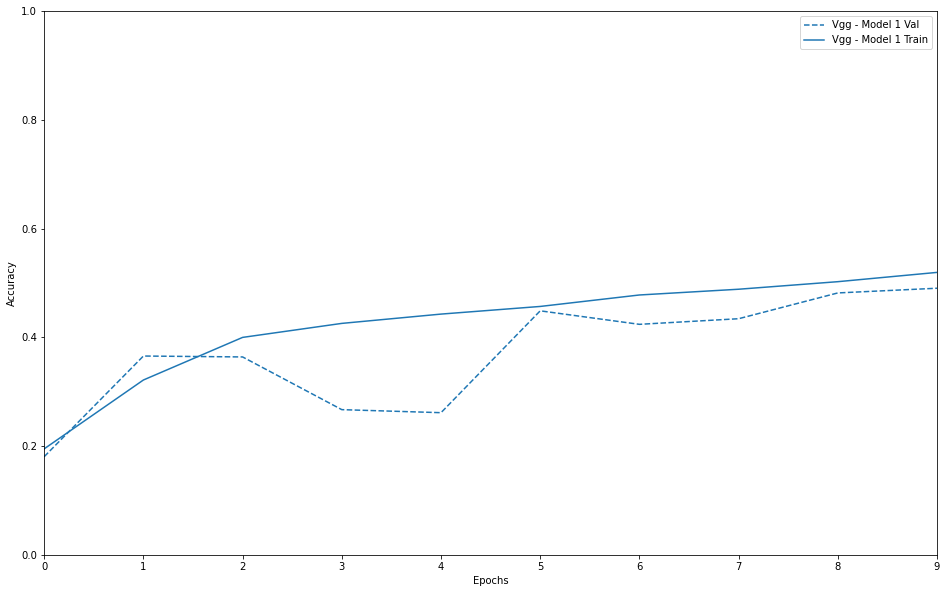

In [85]:
import matplotlib.pyplot as plt

def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  plt.ylim([0,1])

plot_history([('VGG - Model 1', emotion_model_2_history)])

### Build Model VGG16 - Model 2 - with increased capacity 

In [86]:
# Create the model
emotion_model_3 = Sequential()

# Add the vgg convolutional base model
emotion_model_3.add(vgg)
emotion_model_3.add(Flatten())
emotion_model_3.add(Dense(1024, activation='relu'))
emotion_model_3.add(BatchNormalization())
emotion_model_3.add(Dropout(0.25))
emotion_model_3.add(Dense(512, activation='relu'))
emotion_model_3.add(BatchNormalization())
emotion_model_3.add(Dropout(0.25))
emotion_model_3.add(Dense(512, activation='relu'))
emotion_model_3.add(BatchNormalization())
emotion_model_3.add(Dropout(0.25))
emotion_model_3.add(Dense(256, activation='relu'))
emotion_model_3.add(BatchNormalization())
emotion_model_3.add(Dropout(0.25))
emotion_model_3.add(Dense(256, activation='relu'))
emotion_model_3.add(BatchNormalization())
emotion_model_3.add(Dropout(0.25))
emotion_model_3.add(Dense(128, activation='relu'))
emotion_model_3.add(BatchNormalization())
emotion_model_3.add(Dropout(0.25))
emotion_model_3.add(Dense(7, activation= 'softmax'))

emotion_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)              

In [87]:
emotion_model_3.compile(optimizer="adam", 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [88]:
emotion_model_3_history = emotion_model_3.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=7179 // 64)

Epoch 1/10
448/448 [==============================] - 425s 946ms/step - loss: 1.3510 - accuracy: 0.5189 - val_loss: 1.3272 - val_accuracy: 0.5117
Epoch 2/10
448/448 [==============================] - 392s 874ms/step - loss: 1.1821 - accuracy: 0.5703 - val_loss: 1.3679 - val_accuracy: 0.5116
Epoch 3/10
448/448 [==============================] - 399s 891ms/step - loss: 1.1284 - accuracy: 0.5889 - val_loss: 1.4857 - val_accuracy: 0.4964
Epoch 4/10
448/448 [==============================] - 402s 898ms/step - loss: 1.0708 - accuracy: 0.6182 - val_loss: 1.3322 - val_accuracy: 0.5254
Epoch 5/10
448/448 [==============================] - 384s 857ms/step - loss: 1.0117 - accuracy: 0.6404 - val_loss: 1.3534 - val_accuracy: 0.5399
Epoch 6/10
448/448 [==============================] - 375s 838ms/step - loss: 0.9573 - accuracy: 0.6620 - val_loss: 1.3328 - val_accuracy: 0.5357
Epoch 7/10
448/448 [==============================] - 381s 851ms/step - loss: 0.8986 - accuracy: 0.6867 - val_loss: 1.4711 -

In [89]:
print('Maximum training accuracy:', round(max(emotion_model_3_history.history['accuracy'])*100,2))
print('Maximum validation accuracy:', round(max(emotion_model_3_history.history['val_accuracy'])*100,2))

Maximum training accuracy: 76.22
Maximum validation accuracy: 56.56


In [90]:
emotion_model_3.save('saved_model_VGG_2.h5')

In [91]:
model_vgg_2 = keras.models.load_model('saved_model_VGG_2.h5')

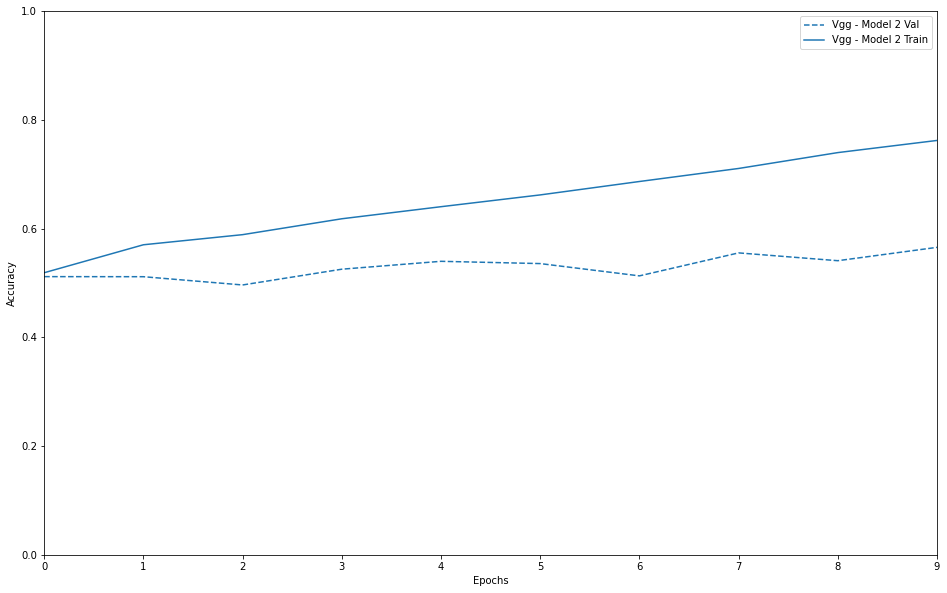

In [92]:
import matplotlib.pyplot as plt

def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  plt.ylim([0,1])

plot_history([('VGG - Model 2', emotion_model_3_history)])

### Build VGG16 - with activation function "sigmoid"

In [93]:
# Create the model
emotion_model_4 = Sequential()

# Add the vgg convolutional base model
emotion_model_4.add(vgg)
emotion_model_4.add(Flatten())
emotion_model_4.add(Dense(1024, activation='sigmoid'))
emotion_model_4.add(BatchNormalization())
emotion_model_4.add(Dropout(0.25))
emotion_model_4.add(Dense(512, activation='sigmoid'))
emotion_model_4.add(BatchNormalization())
emotion_model_4.add(Dropout(0.25))
emotion_model_4.add(Dense(512, activation='sigmoid'))
emotion_model_4.add(BatchNormalization())
emotion_model_4.add(Dropout(0.25))
emotion_model_4.add(Dense(256, activation='sigmoid'))
emotion_model_4.add(BatchNormalization())
emotion_model_4.add(Dropout(0.25))
emotion_model_4.add(Dense(256, activation='sigmoid'))
emotion_model_4.add(BatchNormalization())
emotion_model_4.add(Dropout(0.25))
emotion_model_4.add(Dense(128, activation='sigmoid'))
emotion_model_4.add(BatchNormalization())
emotion_model_4.add(Dropout(0.25))
emotion_model_4.add(Dense(7, activation= 'softmax'))

emotion_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
_________________________________________________________________
batch_normalization_11 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_12 (Batc (None, 512)              

In [94]:
emotion_model_4.compile(optimizer="adam", 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [95]:
emotion_model_4_history = emotion_model_4.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=7179 // 64)

Epoch 1/10
448/448 [==============================] - 337s 750ms/step - loss: 0.9007 - accuracy: 0.7163 - val_loss: 2.1583 - val_accuracy: 0.3629
Epoch 2/10
448/448 [==============================] - 356s 795ms/step - loss: 1.0235 - accuracy: 0.6523 - val_loss: 1.8129 - val_accuracy: 0.3934
Epoch 3/10
448/448 [==============================] - 357s 796ms/step - loss: 1.4803 - accuracy: 0.4367 - val_loss: 1.8389 - val_accuracy: 0.2472
Epoch 4/10
448/448 [==============================] - 350s 781ms/step - loss: 1.8350 - accuracy: 0.2299 - val_loss: 1.8210 - val_accuracy: 0.2471
Epoch 5/10
448/448 [==============================] - 352s 787ms/step - loss: 1.8260 - accuracy: 0.2416 - val_loss: 1.8198 - val_accuracy: 0.2469
Epoch 6/10
448/448 [==============================] - 352s 786ms/step - loss: 1.8220 - accuracy: 0.2469 - val_loss: 1.8160 - val_accuracy: 0.2469
Epoch 7/10
448/448 [==============================] - 343s 765ms/step - loss: 1.8197 - accuracy: 0.2481 - val_loss: 1.8181 -

In [96]:
print('Maximum training accuracy:', round(max(emotion_model_4_history.history['accuracy'])*100,2))
print('Maximum validation accuracy:', round(max(emotion_model_4_history.history['val_accuracy'])*100,2))

Maximum training accuracy: 71.63
Maximum validation accuracy: 39.34


In [97]:
emotion_model_4.save('saved_model_VGG_3.h5')

In [98]:
model_vgg_3 = keras.models.load_model('saved_model_VGG_3.h5')

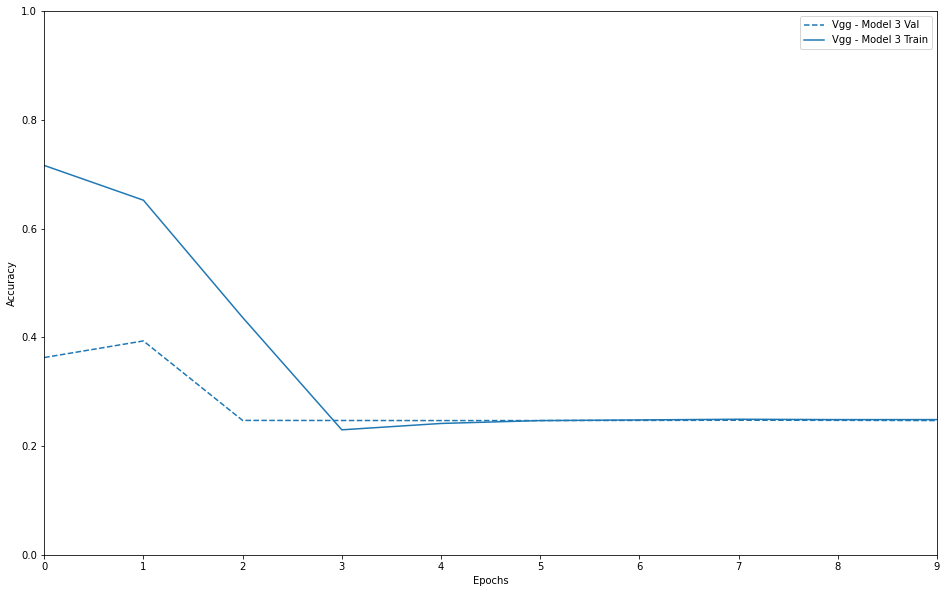

In [99]:
import matplotlib.pyplot as plt

def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])
  plt.ylim([0,1])

plot_history([('VGG - Model 3', emotion_model_4_history)])